# Prediction with PyLogit
The purpose of this notebook is to demonstrate how one can use PyLogit to predict the probabilities of discrete outcomes. The two main use cases are when one has
1. already estimated a model using PyLogit and wants to use the estimated parameters to predict probabilities for a different dataset
2. one or more sets of parameters (obtained from some process other than model estimation with PyLogit) and one wants to use those parameters to predict probabilities.

Both of these uses will be demonstrated below. Essentially, the "predict" function of a model object is the place to go to perform both of these tasks. The exception to this is for mixed logit models, where in addition to the predict function, there is also a "panel predict" function that allows one to condition on past observations for individuals in one's prediction dataset that were also in one's estimation dataset. For more information on the panel_predict method, see chapter 11 ("Individual-Level Parameters") of Discrete Choice Methods with Simulation by Kenneth Train (2009).

The examples below should make all of this clear.

The dataset being used in this notebook is the "Swissmetro" dataset used in the Python Biogeme examples. The data can be downloaded at <a href="http://biogeme.epfl.ch/examples_swissmetro.html">http://biogeme.epfl.ch/examples_swissmetro.html</a>, and a detailed explanation of the variables and data-collection procedure can be found at http://www.strc.ch/conferences/2001/bierlaire1.pdf.

In [1]:
# For recording the model specification 
from collections import OrderedDict

# For making plots pretty
import seaborn
# For file input/output
import pandas as pd
# For vectorized math operations
import numpy as np
# For plotting
import matplotlib.pyplot as plt

# For model estimation and prediction
import pylogit as pl

# To display plots inline
%matplotlib inline                     

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Load the dataset
Note that because we want to demonstrate the use of the dataset for prediction, we will randomly remove 2,000 of the response in the dataset. After estimating the various models, we will then predict the probabilities for these held-out responses.

In [2]:
# Load the dataset
raw_data = pd.read_csv("../data/long_swiss_metro_data.csv")

# Get a list of the choice situation ids that will be used
# in estimation and in prediction
all_situation_ids = np.sort(raw_data["custom_id"].unique())

# Set a random seed for reproducibility
np.random.seed(61)

# Shuffle and split the ids
np.random.shuffle(all_situation_ids)
prediction_ids = all_situation_ids[:2000]
estimation_ids = all_situation_ids[2000:]

# Create the estimation and prediction datasets
estimation_df = raw_data.loc[raw_data["custom_id"].isin(estimation_ids)].copy()
prediction_df = raw_data.loc[raw_data["custom_id"].isin(prediction_ids)].copy()


In [3]:
# Look at the first 5 rows of the data
# Note that for the mode_id, 1-Train, 2-SwissMetro, 3-Car
estimation_df.head().T

,3,4,5,6,7
custom_id,2.000000,2.000000,2.00,3.000000,3.000000
mode_id,1.000000,2.000000,3.00,1.000000,2.000000
CHOICE,0.000000,1.000000,0.00,0.000000,1.000000
GROUP,2.000000,2.000000,2.00,2.000000,2.000000
SURVEY,0.000000,0.000000,0.00,0.000000,0.000000
SP,1.000000,1.000000,1.00,1.000000,1.000000
ID,1.000000,1.000000,1.00,1.000000,1.000000
PURPOSE,1.000000,1.000000,1.00,1.000000,1.000000
FIRST,0.000000,0.000000,0.00,0.000000,0.000000
TICKET,1.000000,1.000000,1.00,1.000000,1.000000


## Create the model specification
As in previous examples, the model specification being used is
$$
\begin{aligned}
V_{i, \textrm{Train}} &= \textrm{ASC Train} + \\
&\quad \beta _{ \textrm{tt_transit} } \textrm{Travel Time} _{ \textrm{Train}} * \frac{1}{60} + \\
&\quad \beta _{ \textrm{tc_train} } \textrm{Travel Cost}_{\textrm{Train}} * \left( GA == 0 \right) * 0.01 + \\
&\quad \beta _{ \textrm{headway_train} } \textrm{Headway} _{\textrm{Train}} * \frac{1}{60} + \\
&\quad \beta _{ \textrm{survey} } \left( \textrm{Train Survey} == 1 \right) \\
\\
V_{i, \textrm{Swissmetro}} &= \textrm{ASC Swissmetro} + \\
&\quad \beta _{ \textrm{tt_transit} } \textrm{Travel Time} _{ \textrm{Swissmetro}} * \frac{1}{60} + \\
&\quad \beta _{ \textrm{tc_sm} } \textrm{Travel Cost}_{\textrm{Swissmetro}} * \left( GA == 0 \right) * 0.01 + \\
&\quad \beta _{ \textrm{headway_sm} } \textrm{Heaway} _{\textrm{Swissmetro}} * \frac{1}{60} + \\
&\quad \beta _{ \textrm{seat} } \left( \textrm{Seat Configuration} == 1 \right) \\
&\quad \beta _{ \textrm{survey} } \left( \textrm{Train Survey} == 1 \right) \\
&\quad \beta _{ \textrm{first_class} } \left( \textrm{First Class} == 0 \right) \\
\\
V_{i, \textrm{Car}} &= \beta _{ \textrm{tt_car} } \textrm{Travel Time} _{ \textrm{Car}} * \frac{1}{60} + \\
&\quad \beta _{ \textrm{tc_car}} \textrm{Travel Cost}_{\textrm{Car}} * 0.01 + \\
&\quad \beta _{\textrm{luggage}=1} \left( \textrm{Luggage} == 1 \right) + \\
&\quad \beta _{\textrm{luggage}>1} \left( \textrm{Luggage} > 1 \right)
\end{aligned}
$$
Here, $i$ is used to denote a particular individual.

In [4]:
# NOTE: - Specification and variable names must be ordered dictionaries.
#       - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         of integers or or lists of lists of integers. Within a list, 
#         or within the inner-most list, the integers should be the 
#         alternative ID's of the alternative whose utility specification 
#         the explanatory variable is entering. Lists of lists denote 
#         alternatives that will share a common coefficient for the variable
#         in question.

basic_specification = OrderedDict()
basic_names = OrderedDict()

basic_specification["intercept"] = [1, 2]
basic_names["intercept"] = ['ASC Train',
                            'ASC Swissmetro']

basic_specification["travel_time_hrs"] = [[1, 2,], 3]
basic_names["travel_time_hrs"] = ['Travel Time, units:hrs (Train and Swissmetro)',
                                  'Travel Time, units:hrs (Car)']

basic_specification["travel_cost_hundreth"] = [1, 2, 3]
basic_names["travel_cost_hundreth"] = ['Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)',
                                       'Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)',
                                       'Travel Cost, units: 0.01 CHF (Car)']

basic_specification["headway_hrs"] = [1, 2]
basic_names["headway_hrs"] = ["Headway, units:hrs, (Train)",
                              "Headway, units:hrs, (Swissmetro)"]

basic_specification["seat_configuration"] = [2]
basic_names["seat_configuration"] = ['Airline Seat Configuration, base=No (Swissmetro)']

basic_specification["train_survey"] = [[1, 2]]
basic_names["train_survey"] = ["Surveyed on a Train, base=No, (Train and Swissmetro)"]

basic_specification["regular_class"] = [1]
basic_names["regular_class"] = ["First Class == False, (Swissmetro)"]

basic_specification["single_luggage_piece"] = [3]
basic_names["single_luggage_piece"] = ["Number of Luggage Pieces == 1, (Car)"]

basic_specification["multiple_luggage_pieces"] = [3]
basic_names["multiple_luggage_pieces"] = ["Number of Luggage Pieces > 1, (Car)"]


## Estimate the various models to be used for prediction
Note that we will first estimate all models that can be estimated with PyLogit. Then we will demonstrate the use of the prediction function for these models.

In [5]:
# The 'alt_id_column' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
alt_id_column = "mode_id"

# The "obs_id_column" is a custom id column that ignores the fact that this is a 
# panel/repeated-observations dataset. This column denotes each individual choice
# situation.
obs_id_column = "custom_id"

# The "choice_column" records the name of the column that denotes whether or not each
# individual chose the alternative on a given row.
choice_column = "CHOICE"

### Estimate the MNL model

In [6]:
# Estimate the multinomial logit model (MNL)
swissmetro_mnl = pl.create_choice_model(data=estimation_df,
                                        alt_id_col=alt_id_column,
                                        obs_id_col=obs_id_column,
                                        choice_col=choice_column,
                                        specification=basic_specification,
                                        model_type="MNL",
                                        names=basic_names)

# Specify the initial values and method for the optimization.
swissmetro_mnl.fit_mle(np.zeros(14))

Log-likelihood at zero: -4,906.5129
Initial Log-likelihood: -4,906.5129
Estimation Time: 0.15 seconds.
Final log-likelihood: -3,668.2772


/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:382: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


### Estimate the Asymmetric Logit Model

In [7]:
# Create the various specification and name dictionaries 
# for the asymmetric logit model. It is the same as for the MNL
# except that it excludes the intercept from V_{i, alternative}.
asym_specification = OrderedDict()
asym_names = OrderedDict()

for col in basic_specification:
    if col != "intercept":
        asym_specification[col] = basic_specification[col]
        asym_names[col] = basic_names[col]

# Get the list of intercept names for the asymmetric logit model
# This is used to tell PyLogit that we will be using 'outside'
# intercept parameters.
# See equation 2 of http://arxiv.org/abs/1606.05900 for more
# details
asym_intercept_names = basic_names["intercept"]
# Specify what alternative is not having its intercept estimated
asym_intercept_ref_pos = 2

# Give names to the shape parameters of the asymmetric logit model
# Note that all of the shape parameters are not identifiable so we
# need to restrict one of them. This accounts for why we do not have
# a "shape_car" name.
asym_shape_names = ["shape_train", "shape_swiss_metro"]

# Note the index of the alternative whose shape parameter is constrained
# (i.e. the Car alternative)
asym_ref = 2

# Create the asymmetric logit's model object
swissmetro_asym = pl.create_choice_model(data=estimation_df,
                                         alt_id_col=alt_id_column,
                                         obs_id_col=obs_id_column,
                                         choice_col=choice_column,
                                         specification=asym_specification,
                                         model_type="Asym",
                                         names=asym_names,
                                         shape_names=asym_shape_names,
                                         intercept_names=asym_intercept_names,
                                         shape_ref_pos=asym_ref,
                                         intercept_ref_pos=asym_intercept_ref_pos)

# Note that, below, we use None for initial values and use kwargs to
# specify our initial values for the optimization. This is not
# necessary, but it is convenient and an option.

# Note that dividing the index coefficients by log(J), where J is
# the number of alternatives in the dataset, accounts for the fact
# that when each shape parameter is 1/J, the value of the asymmetric
# logit model's estimated index coefficients are equal to the logit
# model's estimates, divided by log(J).
# Again, see http://arxiv.org/abs/1606.05900 for more details.

swissmetro_asym.fit_mle(None,
                        init_shapes=np.zeros(2),
                        init_intercepts=swissmetro_mnl.params.values[:2],
                        init_coefs=swissmetro_mnl.params.values[2:] / np.log(3))

Log-likelihood at zero: -4,906.5129
Initial Log-likelihood: -3,668.2772
Estimation Time: 0.42 seconds.
Final log-likelihood: -3,533.2248


### Estimate the Uneven Logit Model

In [8]:
# Create the various specification and name dictionaries 
# for the uneven logit model. It is the same as for the MNL
# except that it excludes the intercept from V_{i, alternative}.
uneven_specification = OrderedDict()
uneven_names = OrderedDict()

for col in basic_specification:
    if col != "intercept":
        uneven_specification[col] = basic_specification[col]
        uneven_names[col] = basic_names[col]

# Get the list of intercept names for the uneven logit model
# This is used to tell PyLogit that we will be using 'outside'
# intercept parameters.
# See equation 2 of http://arxiv.org/abs/1606.05900 for more
# details
uneven_intercept_names = basic_names["intercept"]
# Specify what alternative is not having its intercept estimated
uneven_intercept_ref_pos = 2

# Specify the names of the uneven logit model's shape parameters
# Note that we include "shape_car" because all of the uneven logit
# model's shape parameters are identifiable.
uneven_shape_names = ["shape_train", "shape_swiss_metro", "shape_car"]

swissmetro_uneven = pl.create_choice_model(data=estimation_df,
                                           alt_id_col=alt_id_column,
                                           obs_id_col=obs_id_column,
                                           choice_col=choice_column,
                                           specification=uneven_specification,
                                           model_type="Uneven",
                                           names=uneven_names,
                                           shape_names=uneven_shape_names,
                                           intercept_names=uneven_intercept_names,
                                           intercept_ref_pos=uneven_intercept_ref_pos)


# Also, note that we use None for initial values and use kwargs to
# specify our initial values for the optimaztion. This is necessary
# to use 'outside' intercept parameters with the model.
swissmetro_uneven.fit_mle(None,
                          init_shapes=np.zeros(3),
                          init_intercepts=swissmetro_mnl.params.values[:2],
                          init_coefs=swissmetro_mnl.params.values[2:])


Log-likelihood at zero: -4,906.5129
Initial Log-likelihood: -3,668.2772
Estimation Time: 0.31 seconds.
Final log-likelihood: -3,511.3976


### Estimate the Scobit Model

In [9]:
# Create the various specification and name dictionaries 
# for the scobit model. It is the same as for the MNL
# except that it excludes the intercept from V_{i, alternative}.
scobit_specification = OrderedDict()
scobit_names = OrderedDict()

for col in basic_specification:
    if col != "intercept":
        scobit_specification[col] = basic_specification[col]
        scobit_names[col] = basic_names[col]

# Get the list of intercept names for the scobit model
# This is used to tell PyLogit that we will be using 'outside'
# intercept parameters.
# See equation 2 of http://arxiv.org/abs/1606.05900 for more
# details
scobit_intercept_names = basic_names["intercept"]

# Create the names of the shape parameters that are needed for the scobit model
scobit_shape_names = ["shape_train", "shape_swiss_metro", "shape_car"]

# Specify which intercept/ASC is not being estimated (namely, the Car intercept)
scobit_intercept_ref = 2

swissmetro_scobit = pl.create_choice_model(data=estimation_df,
                                           alt_id_col=alt_id_column,
                                           obs_id_col=obs_id_column,
                                           choice_col=choice_column,
                                           specification=scobit_specification,
                                           model_type="Scobit",
                                           names=scobit_names,
                                           shape_names=scobit_shape_names,
                                           intercept_ref_pos=scobit_intercept_ref,
                                           intercept_names=scobit_intercept_names)

# Note that we are using 'outside' intercept parameters for this model
swissmetro_scobit.fit_mle(None,
                          init_shapes=np.zeros(3),
                          init_intercepts=swissmetro_mnl.params.values[:2],
                          init_coefs=swissmetro_mnl.params.values[2:])

Log-likelihood at zero: -4,906.5129
Initial Log-likelihood: -3,668.2772
Estimation Time: 0.50 seconds.
Final log-likelihood: -3,505.9938


### Estimate the Clog-Log Model

In [10]:
# Create the specification and name dictionaries 
# for the clog-log model.It is the same as for the MNL
# except that it excludes the intercept from V_{i, alternative}.
clog_specification = OrderedDict()
clog_names = OrderedDict()

# Copy the specification dictionary from the logit
# model, without the intercept parameters so we
# can place the intercept parameters outside the
# index
for col in basic_specification:
    if col != "intercept":
        clog_specification[col] = basic_specification[col]
        clog_names[col] = basic_names[col]

# Get the list of intercept names for the clog-log model
# This is used to tell PyLogit that we will be using 'outside'
# intercept parameters.
# See equation 2 of http://arxiv.org/abs/1606.05900 for more
# details
clog_intercept_names = basic_names["intercept"]

# Specify which intercept/ASC is not being estimated 
# (i.e, the Car intercept)
clog_intercept_ref = 2

# Create the Clog-log model object
swissmetro_clog = pl.create_choice_model(data=estimation_df,
                                         alt_id_col=alt_id_column,
                                         obs_id_col=obs_id_column,
                                         choice_col=choice_column,
                                         specification=clog_specification,
                                         model_type="Cloglog",
                                         intercept_ref_pos=clog_intercept_ref,
                                         names=clog_names,
                                         intercept_names=clog_intercept_names)

# Estimate the clog log model. Note we don't pass one single array of
# initial values but instead pass keyword arguments
swissmetro_clog.fit_mle(None,
                        init_intercepts=swissmetro_mnl.params.values[:2],
                        init_coefs=swissmetro_mnl.params.values[2:])

Log-likelihood at zero: -4,906.5129
Initial Log-likelihood: -4,249.4904
Estimation Time: 0.41 seconds.
Final log-likelihood: -3,680.1916


### Estimate a Nested Logit Model
For the purposes of the example we'll simply nest the "existing" modes together and leave the future mode (the SwissMetro) in its own nest.

In [11]:
# Specify the nesting specification.
# I.e. specify the name of the various nests,
# and which alternatives belong to which nests.
nest_membership = OrderedDict()
nest_membership["Future Modes"] = [2]
nest_membership["Existing Modes"] = [1, 3]

# Create the nested logit model object
swissmetro_nested = pl.create_choice_model(data=estimation_df,
                                           alt_id_col=alt_id_column,
                                           obs_id_col=obs_id_column,
                                           choice_col=choice_column,
                                           specification=basic_specification,
                                           model_type="Nested Logit",
                                           names=basic_names,
                                           nest_spec=nest_membership)

# Create the initial values for the nest parameters
# Note: This should be in terms of the reparameterized values
# (i.e. the logit of the inverse of the scale parameter) used
# by PyLogit.
# Also, note that 40 corresponds to a scale parameter that is
# essentially equal to 1, and 5 corresponds to a scale
# parameter just slightly greater than 1.
init_nests = np.array([40, 5])

# Create the initial values for the estimation
initial_values = np.concatenate([init_nests,
                                 swissmetro_mnl.params.values])

# Estimate the nested logit model
# Note we constrain the nesting parameter for nest 1 since
# the Future Modes nest only has 1 alternative in it.
swissmetro_nested.fit_mle(initial_values,
                          constrained_pos=[0])

swissmetro_nested.get_statsmodels_summary()

Log-likelihood at zero: -4,594.2735
Initial Log-likelihood: -3,666.8367
Estimation Time: 0.49 seconds.
Final log-likelihood: -3,575.2522


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Nested Logit Model Regression Results                     
==============================================================================
Dep. Variable:                 CHOICE   No. Observations:                4,768
Model:             Nested Logit Model   Df Residuals:                    4,752
Method:                           MLE   Df Model:                           16
Date:                Thu, 17 Nov 2016   Pseudo R-squ.:                   0.222
Time:                        23:52:23   Pseudo R-bar-squ.:               0.218
converged:                      False   Log-Likelihood:             -3,575.252
                                        LL-Null:                    -4,594.273
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------------------------------
Future Modes                                                      40.0000        nan        nan        nan           nan       nan
Existing Modes                                                    -0.4513      0.121     -3.728      0.000        -0.689    -0.214
ASC Train                                                         -0.6825      0.115     -5.924      0.000        -0.908    -0.457
ASC Swissmetro                                                    -0.1837      0.113     -1.619      0.105        -0.406     0.039
Travel Time, units:hrs (Train and Swissmetro)                     -0.4452      0.026    -17.129      0.000        -0.496    -0.394
Travel Time, units:hrs (Car)                                      -0.3540      0.025    -14.339      0.000        -0.402    -0.306
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)         -0.1932      0.055     -3.505      0.000        -0.301    -0.085
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)    -0.1713      0.049     -3.474      0.001        -0.268    -0.075
Travel Cost, units: 0.01 CHF (Car)                                -0.5397      0.062     -8.742      0.000        -0.661    -0.419
Headway, units:hrs, (Train)                                       -0.2679      0.050     -5.375      0.000        -0.366    -0.170
Headway, units:hrs, (Swissmetro)                                  -0.4575      0.225     -2.031      0.042        -0.899    -0.016
Airline Seat Configuration, base=No (Swissmetro)                  -0.3986      0.103     -3.887      0.000        -0.600    -0.198
Surveyed on a Train, base=No, (Train and Swissmetro)               1.4522      0.112     12.994      0.000         1.233     1.671
First Class == False, (Swissmetro)                                 0.2518      0.061      4.101      0.000         0.131     0.372
Number of Luggage Pieces == 1, (Car)                               0.1595      0.058      2.759      0.006         0.046     0.273
Number of Luggage Pieces > 1, (Car)                                0.7496      0.167      4.495      0.000         0.423     1.076
==================================================================================================================================
"""

### Estimate a Mixed Logit Model
Here, we'll estimate a relatively simple model, allowing for normally distributed sensitivities to travel time and travel cost. The distribution will be across the various individuals in the dataset(note, not across the choice situations of a given individual). The individuals are denoted by the "ID" column.

Given that we're estimating a distribution for sensitivities to time and cost, it makes sense to use a distribution with bounded support like a log-normal distribution. In this way, we could restrict the sensitivities to only being negative. However, Pylogit does not (yet!) support distributions other than the normal distribution for mixed logit.

In [12]:
# Specify the parameters, by name, that are being treated
# as random variables
mixing_variables = (basic_names["travel_time_hrs"] +
                    basic_names["travel_cost_hundreth"])

# Create the mixed logit model object
swissmetro_mixed = pl.create_choice_model(data=estimation_df,
                                          alt_id_col=alt_id_column,
                                          obs_id_col=obs_id_column,
                                          choice_col=choice_column,
                                          specification=basic_specification,
                                          model_type="Mixed Logit",
                                          names=basic_names,
                                          mixing_id_col="ID",
                                          mixing_vars=mixing_variables)

# Create the initial values for estimation.
# Note that we need one value for each beta
# coefficient and for each of the standard deviations
# that will now be estimated.
initial_values = np.concatenate([swissmetro_mnl.params.values,
                                 np.zeros(len(mixing_variables))])

# Estimate the mixed logit model
swissmetro_mixed.fit_mle(initial_values,
                         seed=26,
                         num_draws=400)

swissmetro_mixed.get_statsmodels_summary()

Log-likelihood at zero: -4,906.5129
Initial Log-likelihood: -3,668.2772
Estimation Time: 3.25 minutes.
Final log-likelihood: -2,824.8372


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Mixed Logit Model Regression Results                     
==============================================================================
Dep. Variable:                 CHOICE   No. Observations:                4,768
Model:              Mixed Logit Model   Df Residuals:                    4,749
Method:                           MLE   Df Model:                           19
Date:                Thu, 17 Nov 2016   Pseudo R-squ.:                   0.424
Time:                        23:55:44   Pseudo R-bar-squ.:               0.420
converged:                      False   Log-Likelihood:             -2,824.837
                                        LL-Null:                    -4,906.513
========================================================================================================================================
                                                                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------------------------------------
ASC Train                                                               -2.8480      0.460     -6.190      0.000        -3.750    -1.946
ASC Swissmetro                                                          -2.9022      0.398     -7.299      0.000        -3.682    -2.123
Travel Time, units:hrs (Train and Swissmetro)                           -3.0662      0.178    -17.262      0.000        -3.414    -2.718
Travel Time, units:hrs (Car)                                            -3.7078      0.169    -21.924      0.000        -4.039    -3.376
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)               -5.3458      0.634     -8.435      0.000        -6.588    -4.104
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)          -2.7045      0.330     -8.195      0.000        -3.351    -2.058
Travel Cost, units: 0.01 CHF (Car)                                      -2.8815      0.333     -8.664      0.000        -3.533    -2.230
Headway, units:hrs, (Train)                                             -0.5237      0.117     -4.488      0.000        -0.752    -0.295
Headway, units:hrs, (Swissmetro)                                        -0.9966      0.356     -2.799      0.005        -1.694    -0.299
Airline Seat Configuration, base=No (Swissmetro)                        -0.5921      0.185     -3.195      0.001        -0.955    -0.229
Surveyed on a Train, base=No, (Train and Swissmetro)                     5.8038      0.452     12.852      0.000         4.919     6.689
First Class == False, (Swissmetro)                                       0.9976      0.183      5.441      0.000         0.638     1.357
Number of Luggage Pieces == 1, (Car)                                     1.1681      0.334      3.503      0.000         0.514     1.822
Number of Luggage Pieces > 1, (Car)                                      2.7793      1.030      2.699      0.007         0.761     4.798
Sigma Travel Time, units:hrs (Train and Swissmetro)                      2.2175      0.113     19.692      0.000         1.997     2.438
Sigma Travel Time, units:hrs (Car)                                       1.4464      0.108     13.426      0.000         1.235     1.658
Sigma Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)          2.4709      0.512      4.826      0.000         1.467     3.474
Sigma Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)     1.5809      0.276      5.720      0.000         1.039     2.123
Sigma Travel Cost, units: 0.01 CHF (Car)                                -1.8658      0.315     -5.930      0.000        -2.482    -1.249
========================================================================================================================================
"""

# Predictions using 1 dataset and 1 set of parameters
Here, we will simply predict the probabilities of each available alternative being chosen in each choice situation from the prediction dataset, using all of the models that we estimated above. Note that we will perform two predictions with the Mixed Logit model. One will use the standard "predict" function and the other will use the "panel_predict" function.

In [13]:
# Create an ordered dictionary mapping shortened model
# names to estimated model objects.
model_name_to_obj = OrderedDict()
model_name_to_obj["Clog"] = swissmetro_clog
model_name_to_obj["MNL"] = swissmetro_mnl
model_name_to_obj["Nested"] = swissmetro_nested
model_name_to_obj["Asym"] = swissmetro_asym
model_name_to_obj["Uneven"] = swissmetro_uneven
model_name_to_obj["Scobit"] = swissmetro_scobit
model_name_to_obj["Mixed"] = swissmetro_mixed

# Initialize a dictionary to store the log-likelihoods
# on the prediction dataset.
prediction_log_likelihoods = OrderedDict()
for key in model_name_to_obj:
    prediction_log_likelihoods[key] = None

# Calculate and store the predictions for all models besides
# the mixed logit model. The predictions will be stored on
# prediction_df
for model_name in model_name_to_obj:
    if model_name == "Mixed":
        # Don't make predictions for the Mixed Logit Model
        # using the for-loop
        continue
    else:
        # Get the model object to be used in making predictions
        model_obj = model_name_to_obj[model_name]
        
        # Note that by default, the predict method returns the
        # predicted probabilities for each available alternative
        # for each choice situation.
        prediction_array = model_obj.predict(prediction_df)
        
        # We can use the "return_long_probs" and "choice_col" 
        # keyword arguments to ensure that we only return the 
        # probability of the chosen alternative for each
        # choice situation.
        chosen_predictions = model_obj.predict(prediction_df,
                                               choice_col=choice_column,
                                               return_long_probs=False)
        
        # Calculate the predicted log-likelihood in two ways and,
        # for demonstration, ensure that they agree.
        log_likelihood_calc_1 = np.log(chosen_predictions).sum()
        
        log_predictions = np.log(prediction_array)
        choice_array = prediction_df[choice_column].values
        log_likelihood_calc_2 = choice_array.dot(log_predictions)
        
        assert np.allclose(log_likelihood_calc_1,
                           log_likelihood_calc_2)
        
        # Store the log-likelihood
        prediction_log_likelihoods[model_name] = log_likelihood_calc_1
        
        # Create a column name for the predictions
        prediction_col = model_name + "_Predictions"
        
        # Store the predicted probabilities
        prediction_df[prediction_col] = prediction_array

In [14]:
# Calculate and store the predictions for the mixed logit 
# model using both the predict and panel_predict functions.
# Note that the panel_predict function will condition the
# predictions on the estimation data of each person
# (if there is any)
for prediction_type in ["Mixed", "Mixed_Panel"]:
    if "Panel" not in prediction_type:
        # We set the random seed simply for reproducibility
        predictions = swissmetro_mixed.predict(prediction_df,
                                               seed=2,
                                               num_draws=400)
    else:
        # The arguments are ['data', 'num_draws']
        args = [prediction_df, 400]
        kwargs = {"seed": 2}

        # Note that we can change the return type the same
        # way as with the predict function. Pass
        # return_long_probs = False and 
        # choice_col = choice_column as keyword arguments
        predictions = swissmetro_mixed.panel_predict(*args,
                                                     **kwargs)

    # Create the column name for the predictions
    prediction_col = prediction_type + "_Predictions"
    # Store the predicted probabilities
    prediction_df[prediction_col] = predictions

    # Calculate the log-likelihood
    actual_choices = prediction_df[choice_column].values
    log_predicted_probs = np.log(predictions)

    prediction_log_likelihoods[prediction_type] =\
                        actual_choices.dot(log_predicted_probs)
        

In [15]:
# Look at the predicted log-likelihoods of the various models
pd.Series(prediction_log_likelihoods,
          name="Log-likelihood of Predictions").sort(inplace=False)

Mixed         -1534.343235
Clog          -1516.255638
MNL           -1495.346433
Asym          -1462.023258
Nested        -1461.652262
Scobit        -1451.833670
Uneven        -1447.384942
Mixed_Panel    -947.548620
Name: Log-likelihood of Predictions, dtype: float64

# Predictions using 1 dataset and multiple parameters.
One feature of PyLogit's predict method is that it allows users to pass sets of parameters as a keyword argument (using "param_list"). This allows one to make multiple sets of predictions at once. Such a feature is useful when one has, for instance, a sample of MCMC samples from the posterior distribution of one's model parameters. Alternatively, as we shall see below, this feature is also useful when one wants to plot the log-likelihood function.

To demonstrate how one uses PyLogit to predict probabilities when one has 1 dataset and multiple sets of coefficients, we will simply use the Uneven Logit model. Most models in PyLogit support prediction with multiple sets of coefficients, and all models that support this feature make use of the same "param_list" keyword argument in the predict method.

The two times where prediction with multiple parameters <strong><u>is not</u></strong> suppored is in the Nested Logit model and in the "panel_predict" method of the Mixed Logit model. Note that the "standard" predict method of the Mixed Logit model <strong><u>does</u></strong> support prediction with multiple parameters.

### Creating multiple sets of parameters
Here, we will assume that we want to plot the in-sample (i.e. estimation set) log-likelihood with respect to the travel cost parameter for the car.

First, let's look at the summary for the Uneven Logit model.

In [16]:
swissmetro_uneven.get_statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Multinomial Uneven Logit Model Regression Results                     
==========================================================================================
Dep. Variable:                             CHOICE   No. Observations:                4,768
Model:             Multinomial Uneven Logit Model   Df Residuals:                    4,751
Method:                                       MLE   Df Model:                           17
Date:                            Thu, 17 Nov 2016   Pseudo R-squ.:                   0.284
Time:                                    23:55:54   Pseudo R-bar-squ.:               0.281
converged:                                  False   Log-Likelihood:             -3,511.398
                                                    LL-Null:                    -4,906.513
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------------------------------
shape_train                                                        1.0271      0.141      7.274      0.000         0.750     1.304
shape_swiss_metro                                                  0.1120      0.232      0.482      0.630        -0.343     0.567
shape_car                                                         -0.4157      0.561     -0.741      0.458        -1.515     0.683
ASC Train                                                         -1.1675      0.240     -4.873      0.000        -1.637    -0.698
ASC Swissmetro                                                    -0.6523      0.234     -2.785      0.005        -1.111    -0.193
Travel Time, units:hrs (Train and Swissmetro)                     -0.3399      0.051     -6.621      0.000        -0.441    -0.239
Travel Time, units:hrs (Car)                                      -0.9527      0.591     -1.611      0.107        -2.112     0.207
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)         -0.2552      0.071     -3.573      0.000        -0.395    -0.115
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)    -0.2218      0.061     -3.648      0.000        -0.341    -0.103
Travel Cost, units: 0.01 CHF (Car)                                -0.5969      0.404     -1.479      0.139        -1.388     0.194
Headway, units:hrs, (Train)                                       -0.2833      0.056     -5.086      0.000        -0.392    -0.174
Headway, units:hrs, (Swissmetro)                                  -0.4631      0.220     -2.102      0.036        -0.895    -0.031
Airline Seat Configuration, base=No (Swissmetro)                  -0.1097      0.108     -1.015      0.310        -0.321     0.102
Surveyed on a Train, base=No, (Train and Swissmetro)               2.0947      0.238      8.809      0.000         1.629     2.561
First Class == False, (Swissmetro)                                 0.1665      0.064      2.598      0.009         0.041     0.292
Number of Luggage Pieces == 1, (Car)                               0.5712      0.365      1.565      0.118        -0.144     1.286
Number of Luggage Pieces > 1, (Car)                                2.1772      0.967      2.251      0.024         0.281     4.073
==================================================================================================================================
"""

In particular, we want to plot the log-likelihood in the range of -1 to 0 for the travel cost parameter for the car utility. To do so, we will generate 100 values of between -1 and 0, containing the true parameter value.

In [17]:
# Create an array of 100 travel cost parameters between
# Note that the travel cost parameter of interest is
# the tenth parameter, and python is zero indexed so we
# use 9 to access its value
actual_travel_cost_param = swissmetro_uneven.params.iat[9]

low_travel_cost_params = np.linspace(-1,
                                     actual_travel_cost_param,
                                     num=50,
                                     endpoint=False)

high_travel_cost_params = np.linspace(actual_travel_cost_param,
                                      0,
                                      num=50,
                                      endpoint=True)

travel_cost_params = np.concatenate((low_travel_cost_params,
                                     high_travel_cost_params))

Next, we'll create a 2D parameter array that contains all the sets of parameters. On the rows will be the particular parameters, and on the columns will be the sets of parameters.

In [18]:
# Initialize the 2D parameter array
param_array_2d = (swissmetro_uneven.params.values[:, None] *
                  np.ones(travel_cost_params.size)[None, :])

# "Fill in" the row for the travel cost parameter for cars
param_array_2d[9, :] = travel_cost_params

# Let's look at the array to make sure we created it correctly
param_array_2d[:, :4]

array([[ 1.02708012,  1.02708012,  1.02708012,  1.02708012],
       [ 0.11201881,  0.11201881,  0.11201881,  0.11201881],
       [-0.41569969, -0.41569969, -0.41569969, -0.41569969],
       [-1.16746396, -1.16746396, -1.16746396, -1.16746396],
       [-0.65231139, -0.65231139, -0.65231139, -0.65231139],
       [-0.33994783, -0.33994783, -0.33994783, -0.33994783],
       [-0.95266145, -0.95266145, -0.95266145, -0.95266145],
       [-0.25521738, -0.25521738, -0.25521738, -0.25521738],
       [-0.221815  , -0.221815  , -0.221815  , -0.221815  ],
       [-1.        , -0.99193809, -0.98387617, -0.97581426],
       [-0.28331413, -0.28331413, -0.28331413, -0.28331413],
       [-0.4630699 , -0.4630699 , -0.4630699 , -0.4630699 ],
       [-0.1097036 , -0.1097036 , -0.1097036 , -0.1097036 ],
       [ 2.09467556,  2.09467556,  2.09467556,  2.09467556],
       [ 0.16650129,  0.16650129,  0.16650129,  0.16650129],
       [ 0.57115182,  0.57115182,  0.57115182,  0.57115182],
       [ 2.17715196,  2.

Finally, PyLogit requires users to be explicit about the sets of parameters being passed as nest, shape, outside intercept, and index parameters. Note that index parameters are also referred to as utility coefficients. This level of explicitness is intended to help prevent errors, and it facilitates internal testing of the passed values.

To comply with the requirements of the method, we have to break apart the newly created parameter array into the four sets of parameters just mentioned: nest, shape, outside intercept, and index parameters.

In [19]:
# Since this is not a nested logit we have no nest parameters
nest_2d = None
# The uneven logit has 3 shape parameters so 
# we select the first 3 rows.
shapes_2d = param_array_2d[:3, :]
# The uneven logit has 2 outside intercept parameters
# so we select the 4th and 5th rows
intercepts_2d = param_array_2d[3:5, :]
# Finally, the remaining parameters are the index coefficients
index_coefs_2d = param_array_2d[5:, :]

# Now, we pack all these arrays together in a list
# Note that the order is intentional and it is a requirement
# for the predict method.
parameter_list = [index_coefs_2d,
                  intercepts_2d,
                  shapes_2d,
                  nest_2d]

With the parameter list created, we can finally perform the prediction. To facilitate easy calculation of the log-likelihoods, given each set of parameter values, we will only return the chosen probabilities of each choice situation.

### Performing the actual prediction

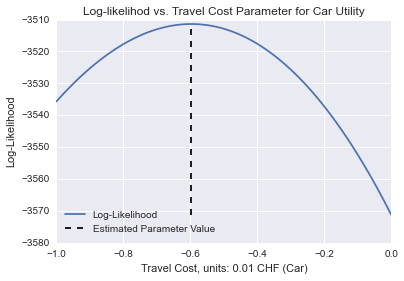

In [20]:
# Pack the keyword arguments into a dictionary, simply for
# line length considerations
kwargs = {"param_list": parameter_list,
          "return_long_probs": False,
          "choice_col": choice_column}

# Calculate the predictions for each set of parameter values
# Note that the returned array will have one column per
# set of parameter values and one row per choice situation
multiple_predictions = swissmetro_uneven.predict(estimation_df,
                                                 **kwargs)

# Calculate and plot the resulting log-likelihood
# Take the log of the probabilities of the chosen alternatives
# for each choice situation and sum them. log_likelihoods
# will be a 1D array of shape (travel_cost_params.size, )
log_likelihoods = np.log(multiple_predictions).sum(axis=0)

plt.plot(travel_cost_params,
         log_likelihoods,
         label="Log-Likelihood")
plt.vlines(actual_travel_cost_param,
           log_likelihoods.min(),
           swissmetro_uneven.log_likelihood,
           linestyle='dashed',
           label="Estimated Parameter Value")
plt.xlabel("Travel Cost, units: 0.01 CHF (Car)")
plt.ylabel("Log-Likelihood")
plt.title("Log-likelihod vs. Travel Cost Parameter for Car Utility")
plt.legend(loc='best')
plt.show()